In [1]:
import pandas as pd
import requests
import holidays
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error
import warnings

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=28, titlepad=10,
       titlecolor='red'
      )

warnings.filterwarnings('ignore')

custom_style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white'}
sns.set_style("darkgrid", rc=custom_style)
plt.style.use("dark_background")

In [2]:
TRAIN_DF = "../data/train.csv"
TEST_DF = "../data/test.csv"

train_df = pd.read_csv(TRAIN_DF)
test_df = pd.read_csv(TEST_DF)

train_df.date = pd.DatetimeIndex(train_df.date)
test_df.date = pd.DatetimeIndex(test_df.date)

train_df['test'] = 0
test_df['test'] = 1

In [3]:
train_df.describe()

,id,date,num_sold,test
count,230130.000000,230130,221259.000000,230130.0
mean,115064.500000,2013-07-02 00:00:00,752.527382,0.0
min,0.000000,2010-01-01 00:00:00,5.000000,0.0
25%,57532.250000,2011-10-02 00:00:00,219.000000,0.0
50%,115064.500000,2013-07-02 00:00:00,605.000000,0.0
75%,172596.750000,2015-04-02 00:00:00,1114.000000,0.0
max,230129.000000,2016-12-31 00:00:00,5939.000000,0.0
std,66432.953062,NaN,690.165445,0.0


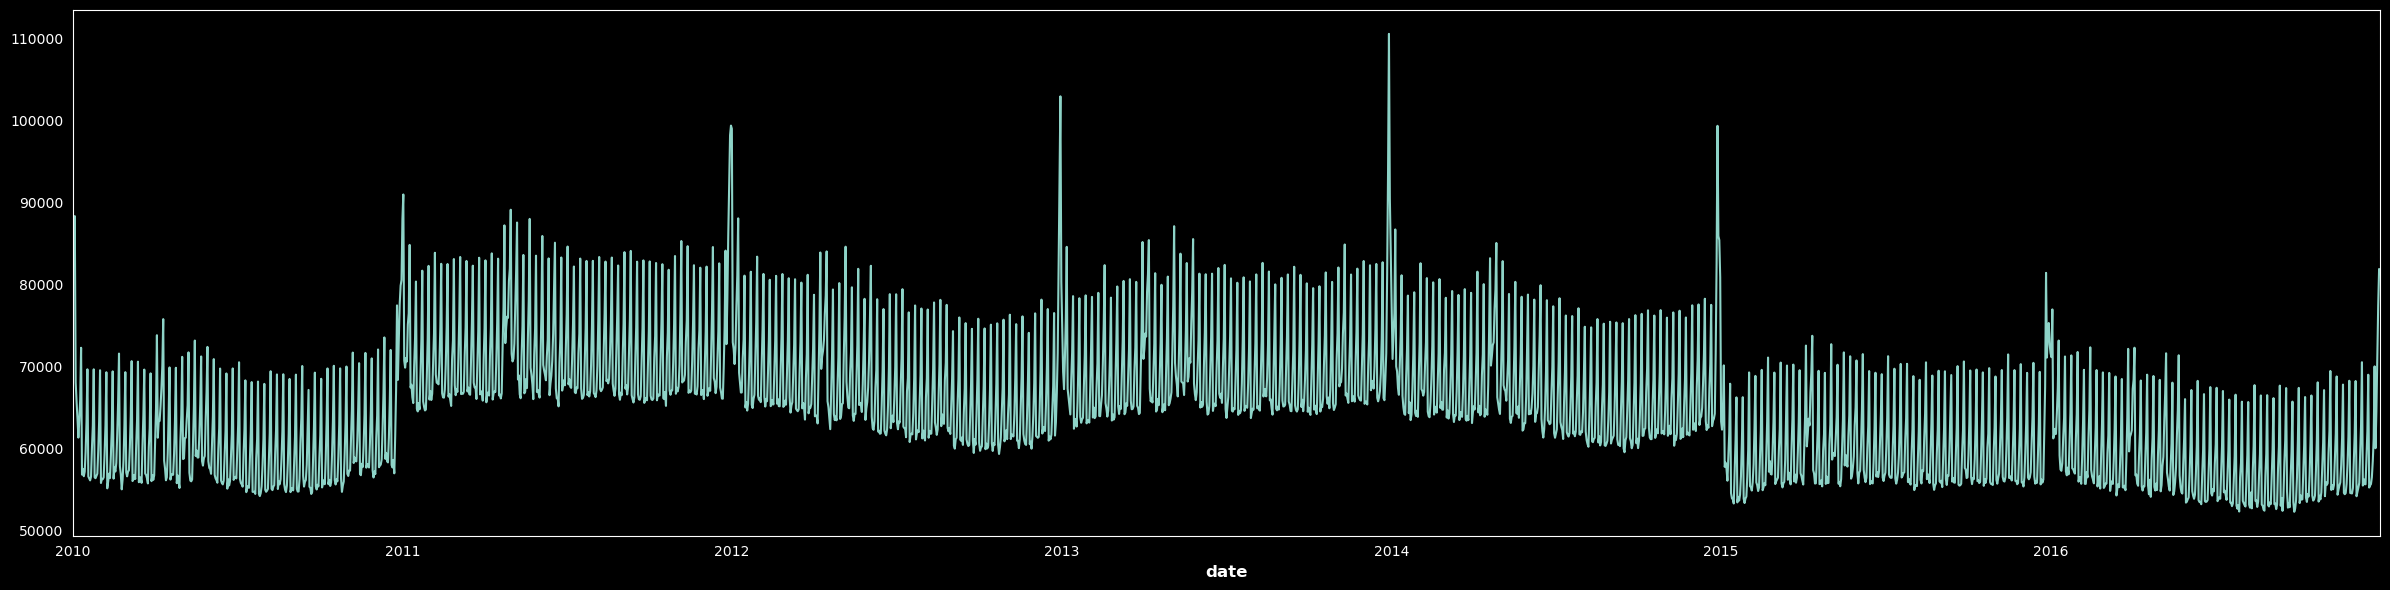

In [4]:
plt.figure(figsize=(24, 6))
train_df.groupby('date')['num_sold'].sum().plot()   
plt.grid()
plt.show();

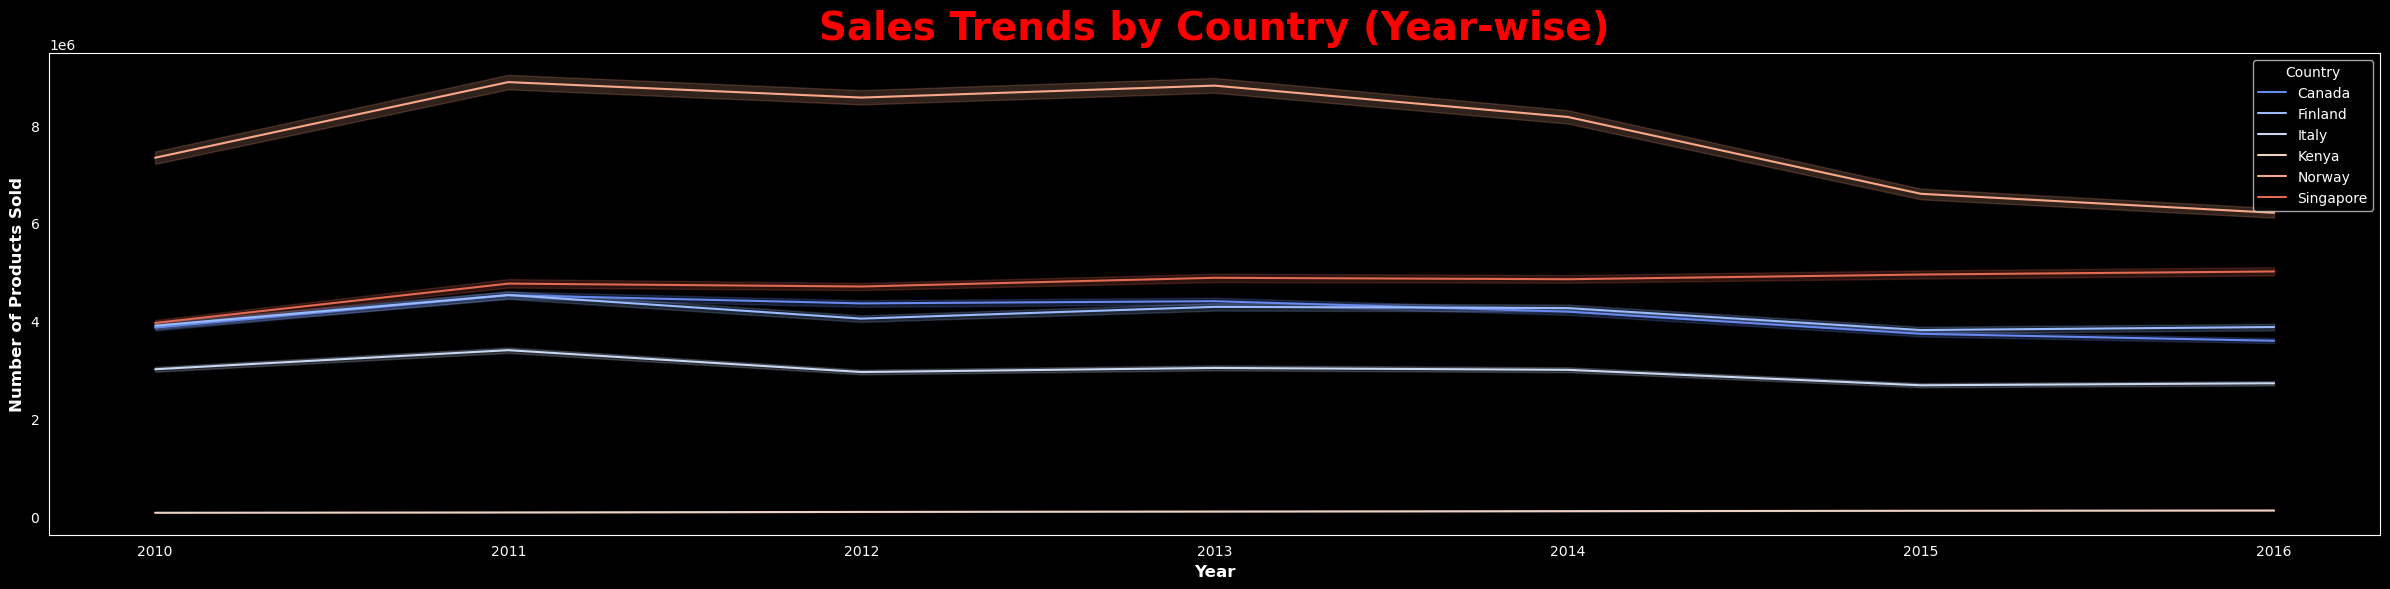

In [5]:
plt.figure(figsize=(24, 6))
sns.lineplot(x=train_df['date'].dt.year, y=train_df['num_sold'], hue=train_df['country'], estimator='sum', palette='coolwarm')
plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

In [6]:
class CFG:
    years_train = train_df.date.dt.year.unique()
    years_test = test_df.date.dt.year.unique()
    years = pd.concat([train_df, test_df]).date.dt.year.unique()
    
    validation_year = 2018
    
    countries = train_df.country.unique()
    stores = train_df.store.unique()
    products = train_df['product'].unique()
    
    alpha3 = {
        'Finland': 'FIN',
        'Canada': 'CAN',
        'Italy': 'ITA',
        'Kenya': 'KEN',
        'Norway': 'NOR',
        'Singapore': 'SGP',
    } # to get per capita GDP
    fft_filter_width = 8
    
    countries_21 = {
        'Finland': 'FI',
        'Canada': 'CA',
        'Italy': 'IT',
        'Kenya': 'KE',
        'Norway': 'NO',
        'Singapore': 'SG',
    } # to get holidays
    holiday_response_len = 10
    
    sincoscol = ['sin t', 'cos t', 'sin t/2', 'cos t/2']
    sincoscol2 = ['sin2t', 'cos 2t', *sincoscol]

In [7]:
abt = pd.concat([train_df, test_df])

abt['year'] = abt.date.dt.year
abt['month'] = abt.date.dt.month
abt['weekday'] = abt.date.dt.weekday
abt['dayofyear'] = abt.date.dt.dayofyear
abt['daynum'] = (abt.date - abt.date.iloc[0]).dt.days
abt['weeknum'] = abt.daynum // 7


dayisinyear = (abt.groupby('year').id.count() / len(CFG.countries) / len(CFG.stores) / len(CFG.products)).rename('dayisinyear').astype(int).to_frame()
abt = abt.merge(dayisinyear, on='year', how='left')
abt['partofyear'] = (abt['dayofyear'] - 1) / abt['dayisinyear'] # sinusoidal
abt['partof2year'] = abt['dayofyear'] + abt['year'] % 2 # sinusoidal
abt['sin 4t'] = np.sin(8 * np.pi * abt['partofyear'])  
abt['cos 4t'] = np.cos(8 * np.pi * abt['partofyear'])
abt['sin 3t'] = np.sin(6 * np.pi * abt['partofyear'])
abt['cos 3t'] = np.cos(6 * np.pi * abt['partofyear'])
abt['sin 2t'] = np.sin(4 * np.pi * abt['partofyear'])
abt['cos 2t'] = np.cos(4 * np.pi * abt['partofyear'])
abt['sin t'] = np.sin(2 * np.pi * abt['partofyear'])
abt['cos t'] = np.cos(2 * np.pi * abt['partofyear']) # partofyear takes half a year to complete
abt['sin t/2'] = np.sin(np.pi * abt['partof2year']) # partof2year takes a year to complete
abt['cos t/2'] = np.cos(np.pi * abt['partof2year'])
abt.drop(['partofyear', 'partof2year', 'dayisinyear'], axis=1, inplace=True)

In [66]:
# ## GDP per capita
# def get_gdp_per_capita(country, year):
#     url = f'https://api.worldbank.org/v2/country/{CFG.alpha3[country]}/indicator/NY.GDP.PCAP.CD?date={year}&format=json'
#     response = requests.get(url)
#     return response.json()[1][0]['value']

# gdp = np.array([[get_gdp_per_capita(country, year) for year in CFG.years] for country in CFG.countries])
# gdp_df = pd.DataFrame(gdp, columns=CFG.years, index=CFG.countries)

gdp_df = pd.read_csv("../data/gdp_per_capita.csv")
gdp_df.index = CFG.countries
gdp_df.columns = CFG.years

abt['gdp_factor'] = None
for year in CFG.years:
    for country in CFG.countries:
        abt.loc[(abt.year == year) & (abt.country == country), 'gdp_factor'] = gdp_df.loc[country, year]
gdp_df.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Canada,47560.666601,52223.858840,52670.344734,52638.118724,50960.843117,43594.194105,42314.061582,45129.628117,46539.176157,46352.869345
Finland,46506.291902,51060.324259,47551.674084,49691.014520,50073.776082,42560.345677,43451.256244,46085.017474,49654.249704,48358.180777
Italy,36184.711870,38851.388134,35235.798906,35747.707953,35750.719750,30387.129319,31126.324695,32554.146685,34746.344139,33812.788725
Kenya,1091.518731,1096.144998,1285.005362,1370.878852,1482.815663,1489.119598,1554.126103,1667.484472,1836.452755,1960.408089
Norway,88163.208593,101221.813477,102175.919298,103553.840134,97666.695184,74809.965805,70867.360997,76131.838403,82792.842711,76430.588947


In [87]:
abt_no_ken_can = abt[~abt.country.isin(['Kenya', 'Canada'])] # keya and canada contains NaN values
store_df = abt_no_ken_can.groupby(by='store').num_sold.mean().rename('store_factor').to_frame()
abt = abt.drop('store_factor', axis=1, errors='ignore').join(store_df, on='store', how='left')

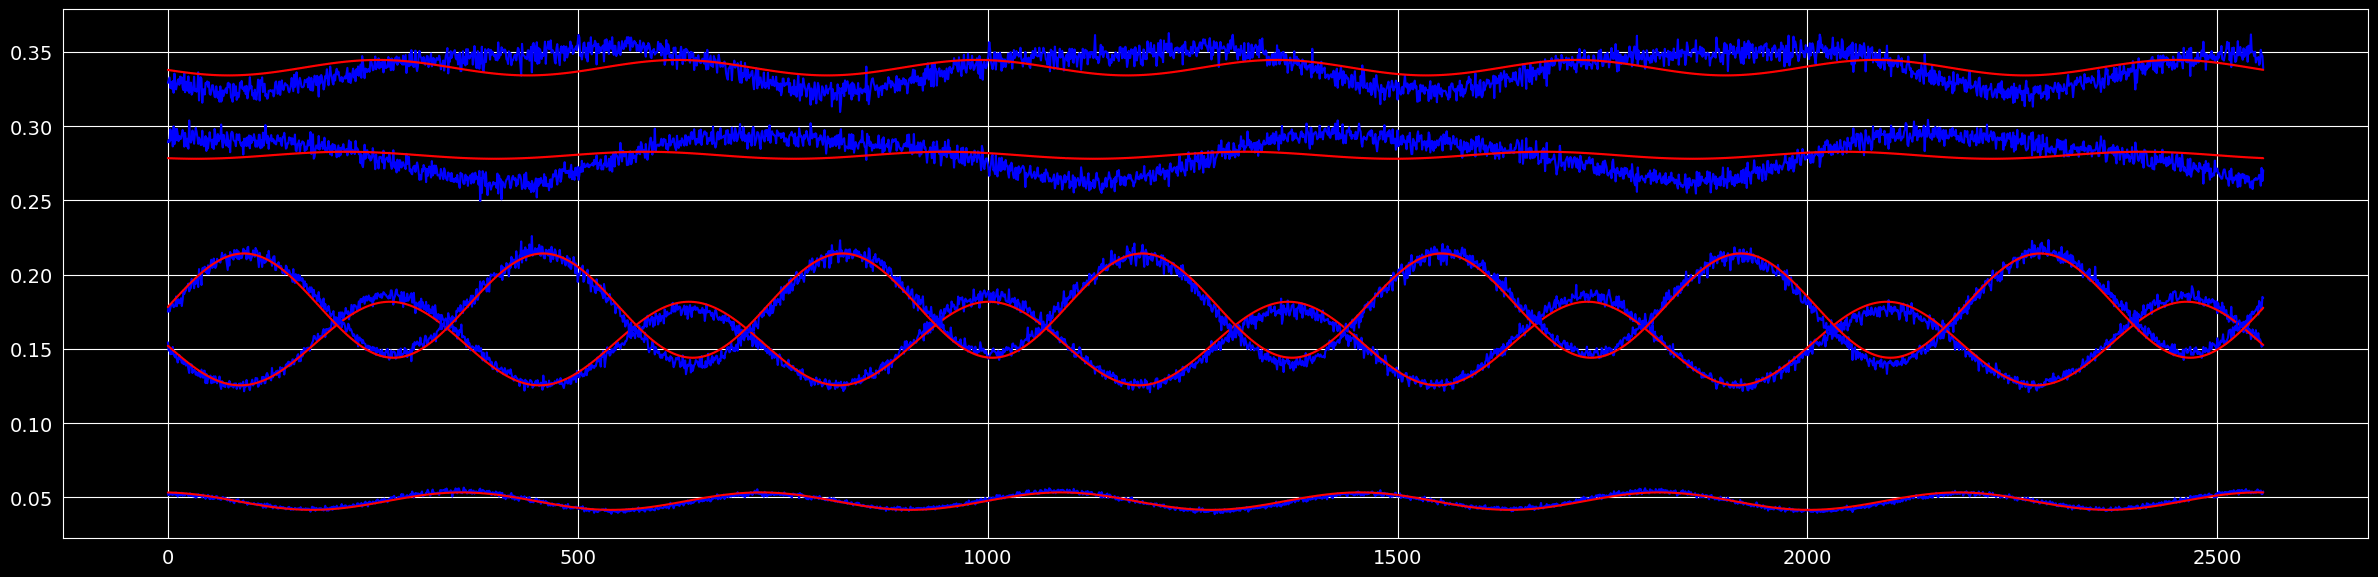

In [88]:
abt_no_ken_can = abt[~abt.country.isin(['Kenya', 'Canada'])].copy()

total = abt_no_ken_can.groupby(by='date').num_sold.sum().rename('num_sold_total')
abt_no_ken_can = abt_no_ken_can.join(total, on='date', how='left')
abt_no_ken_can['num_sold_ratio'] = abt_no_ken_can['num_sold'] / abt_no_ken_can['num_sold_total']

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(24, 6))
abt['product_factor'] = None
for product in CFG.products:
    abt_no_ken_can_date = abt_no_ken_can[(abt_no_ken_can['product'] == product) & (abt_no_ken_can.test == 0)].groupby('date')
    
    x = abt_no_ken_can_date[CFG.sincoscol].mean().to_numpy()
    y = abt_no_ken_can_date.num_sold_ratio.sum().to_numpy()
    
    reg = Ridge(alpha=0.1).fit(x, y)
    p = reg.predict(x)
    abt.loc[(abt['product'] == product), 'product_factor'] = reg.predict(abt.loc[(abt['product'] == product), CFG.sincoscol].to_numpy())
    
    plt.plot(y,'b')
    plt.plot(p,'r')
    
plt.show();

In [79]:
abt['holiday'] = 0

for country in CFG.countries:
    days = [str(day) for day in holidays.CountryHoliday(CFG.countries_21[country], years=CFG.years).items()]
    abt.loc[(abt['country'] == country) & (abt['date'].dt.date.astype(str).isin(days)), 'holiday'] = 1


num_sold_per_week_country_week_day = abt.groupby(['weeknum', 'country', 'weekday'])['num_sold'].sum().reset_index().pivot(index=['weeknum', 'country'], columns='weekday')

ratio_sold_per_week_country_weekday = num_sold_per_week_country_week_day.apply(lambda row: row/sum(row),axis=1).reset_index()

ratio_weekday = pd.DataFrame(columns=CFG.countries, data=[[0, ]*len(CFG.countries)]*7)
for n, country in enumerate(CFG.countries):
    for d in range(7):
        dt = ratio_sold_per_week_country_weekday.loc[ratio_sold_per_week_country_weekday.country == country, ('num_sold', d)][:-60]
        ratio_weekday.loc[d, country] = dt.median()
        
ratio_weekday_mean = ratio_weekday.mean(axis=1)
ratio_weekday['mean'] = ratio_weekday_mean

abt['weekday_factor'] = abt.weekday.map(ratio_weekday_mean)

abt['ratio'] = abt['gdp_factor'] * abt['product_factor'] * abt['store_factor'] * abt['weekday_factor']
abt['total'] = abt['num_sold'] * abt['ratio']

num_sold_per_week_country_week_day.head()

num_sold                                                      
weekday                0        1        2        3        4        5        6
weeknum country                                                               
0       Canada   11823.0  11505.0  11276.0  10806.0  15099.0  14841.0  15614.0
        Finland  11935.0  11734.0  11294.0  10839.0  15360.0  14352.0  15527.0
        Italy     9145.0   9170.0   8744.0   8355.0  11645.0  10888.0  12015.0
        Kenya      232.0    226.0    209.0    198.0    293.0    286.0    303.0
        Norway   22766.0  21481.0  20648.0  20148.0  27923.0  27178.0  29053.0

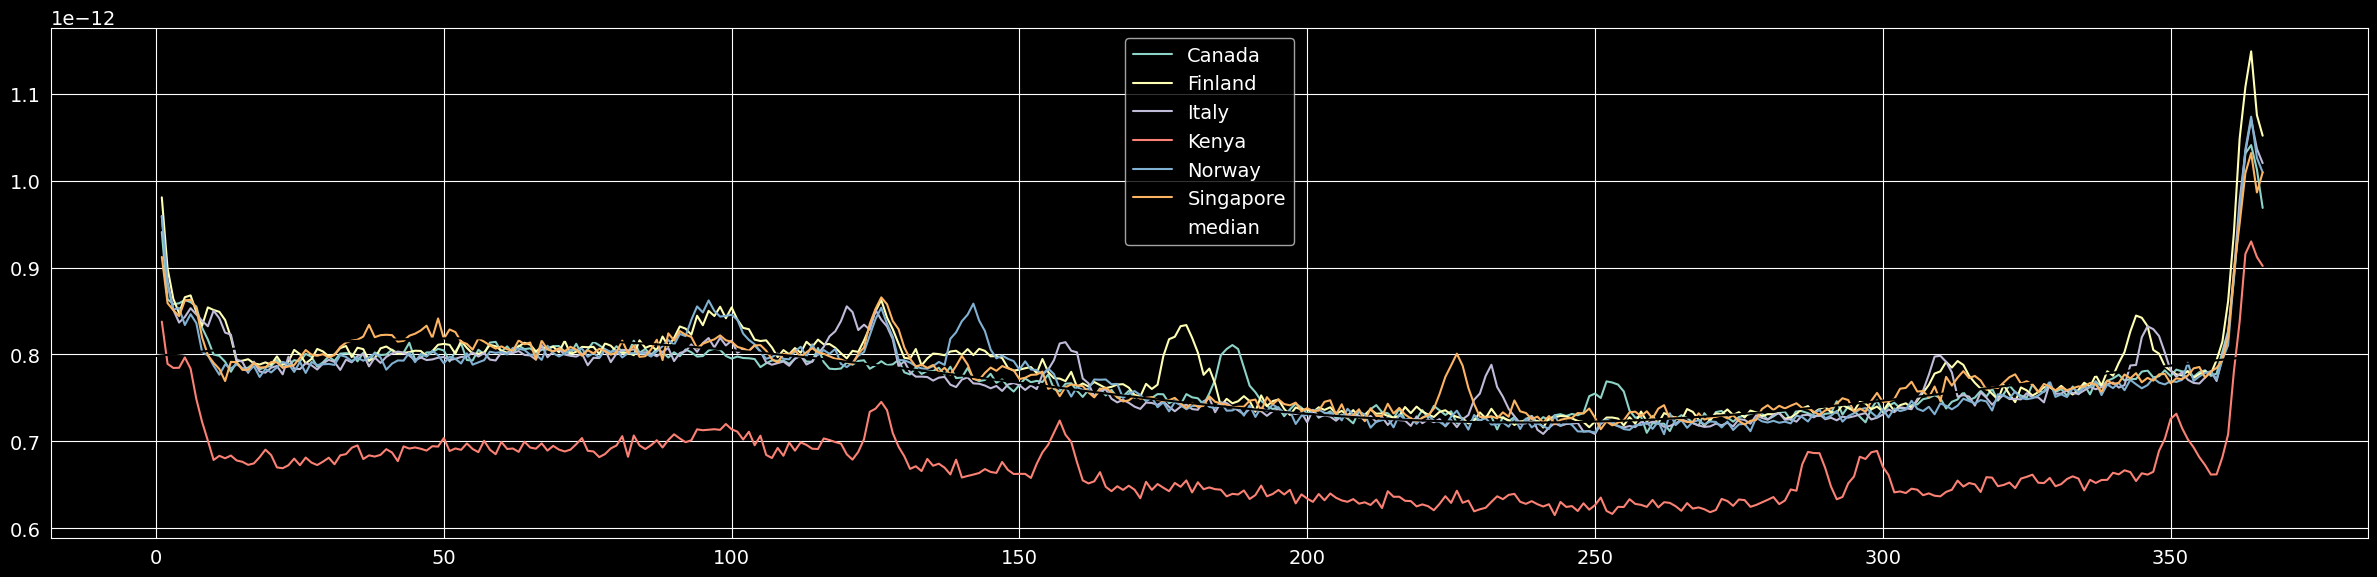

In [84]:
abt_holidays = abt.copy()
abt_holidays['holiday_response'] = 0
for country in CFG.countries:
    for holiday, _ in holidays.CountryHoliday(CFG.countries_21[country], years=CFG.years).items():
        abt_holidays.loc[(abt_holidays['country'] == country) & abt_holidays['date'].isin(pd.date_range(holiday, periods=CFG.holiday_response_len)), 'holiday_response'] = 1
        
fig = plt.figure(figsize=(24, 6))
data = pd.DataFrame()

for n, country in enumerate(CFG.countries):
    dt = abt_holidays[(abt_holidays['country'] == country) & (abt_holidays['test'] == 0)].groupby('dayofyear')['total'].median()
    data[country] = dt
    plt.plot(dt, label=country)
    
data['median'] = data.median(axis=1)

# linear regressio on forier series
x = data.index.to_numpy()
y = data['median'].to_numpy()
fourier = lambda t: np.array([np.sin(2 * np.pi/365 * t), np.cos(2 * np.pi/365 * t)])

year_ratio = Ridge(alpha=0.1).fit(fourier(x).T, y.T).predict(fourier(np.arange(1, 366)).T)
year_ratio = np.append(year_ratio, year_ratio[-1])

abt['dayofyear_factor'] = abt['dayofyear'].map(dict(zip(range(1, 367), year_ratio)))

abt['ratio'] = abt['gdp_factor'] * abt['product_factor'] * abt['store_factor'] * abt['weekday_factor'] * abt['dayofyear_factor']
abt['total'] = abt['num_sold'] / abt['ratio']

plt.plot(year_ratio, 'k', label='median')
plt.legend();

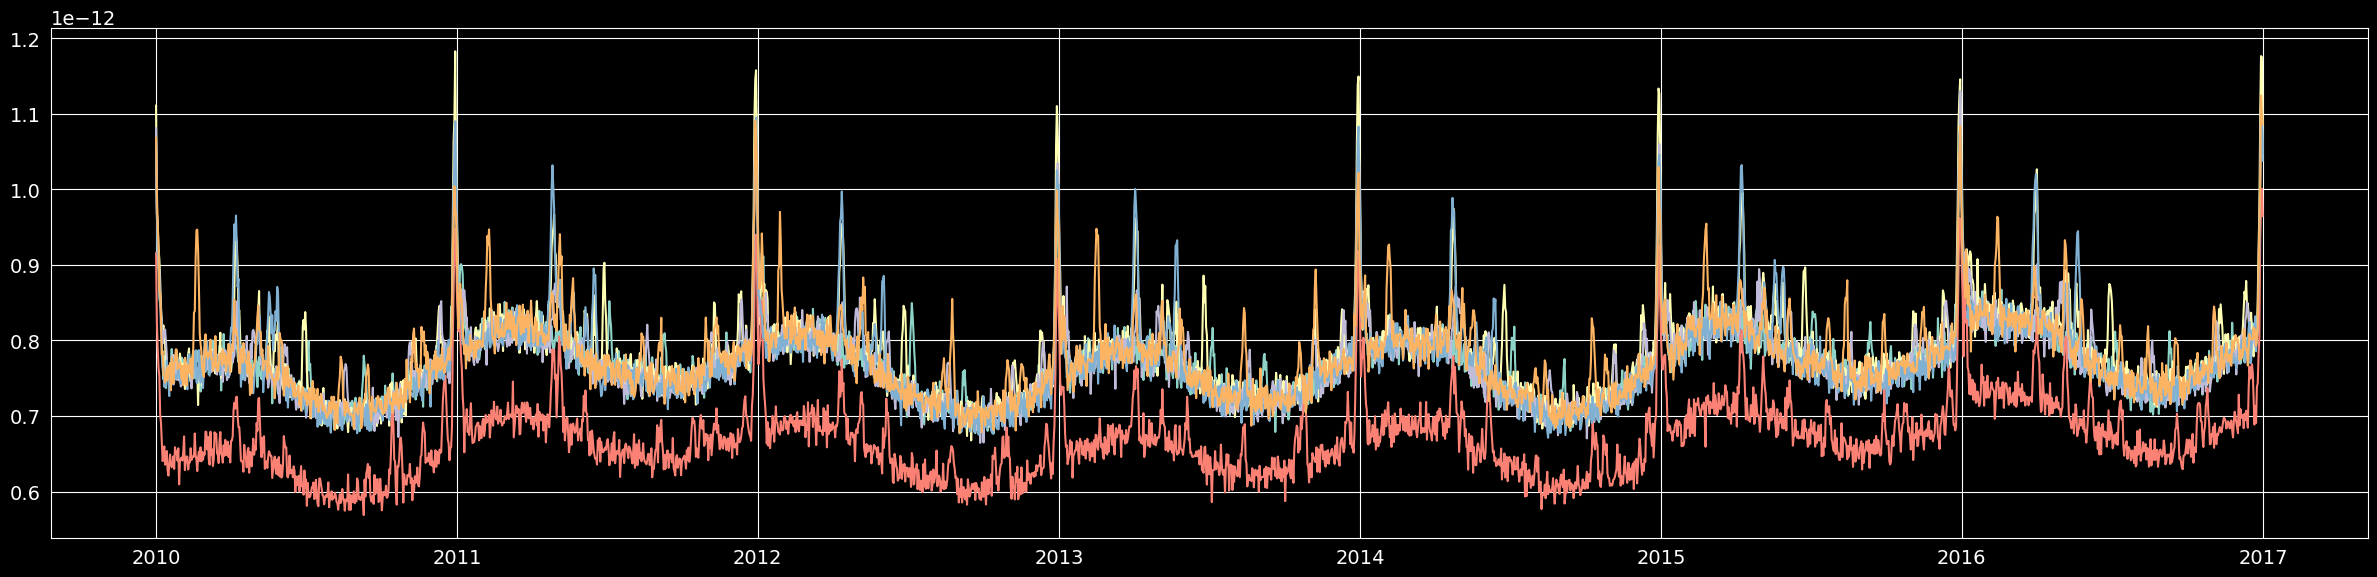

In [85]:
fig = plt.figure(figsize=(24, 6))
data = pd.DataFrame()
for n, country in enumerate(CFG.countries):
    dt = abt_holidays[(abt_holidays['country'] == country) & (abt_holidays['test'] == 0)].groupby('date')['total'].median()
    data[country] = dt
    plt.plot(dt, label=country)

data['median'] = data.median(axis=1)

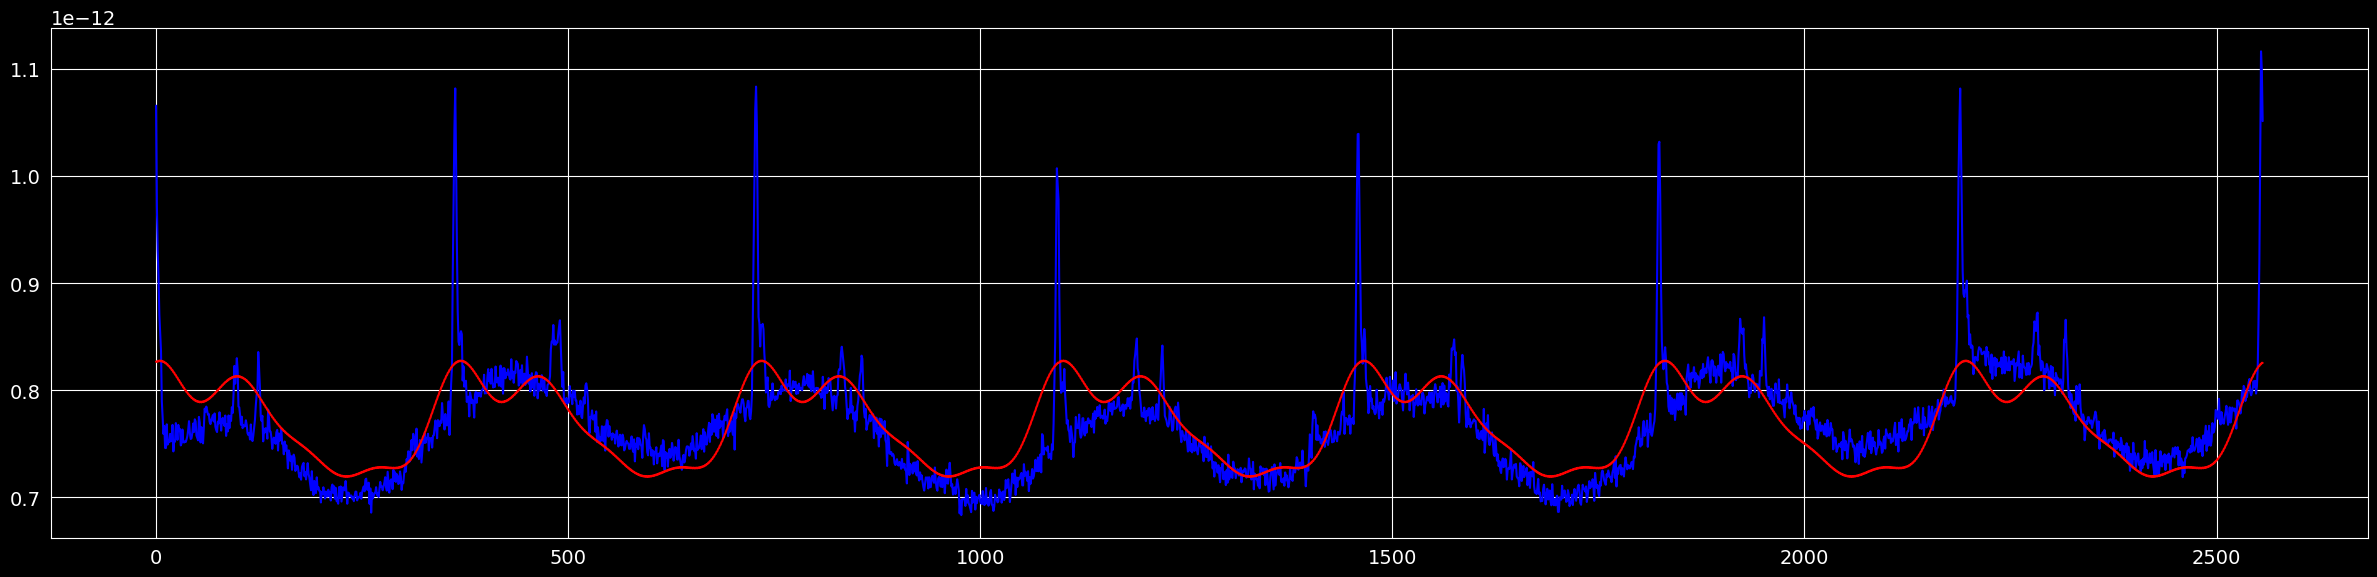

In [86]:
CFG.sincoscol2 = ['sin 4t', 'cos 4t', 'sin 3t', 'cos 3t', 'sin 2t', 'cos 2t', 'sin t', 'cos t', 'sin t/2', 'cos t/2']

dfsc = abt[abt.test == 0].groupby('date')[CFG.sincoscol2].mean()
dfsc['median'] = data.median(axis=1)

x = dfsc[~pd.isna(dfsc['median'])][CFG.sincoscol2].to_numpy()
y = dfsc[~pd.isna(dfsc['median'])]['median'].to_numpy()

reg = Ridge(alpha=0.1, fit_intercept=True).fit(x, y)

fig = plt.figure(figsize=(24, 6))
plt.plot(y, 'b')
plt.plot(reg.predict(x), 'r')

abt['sincos_factor'] = reg.intercept_ + (abt[CFG.sincoscol2] * reg.coef_).sum(axis=1)

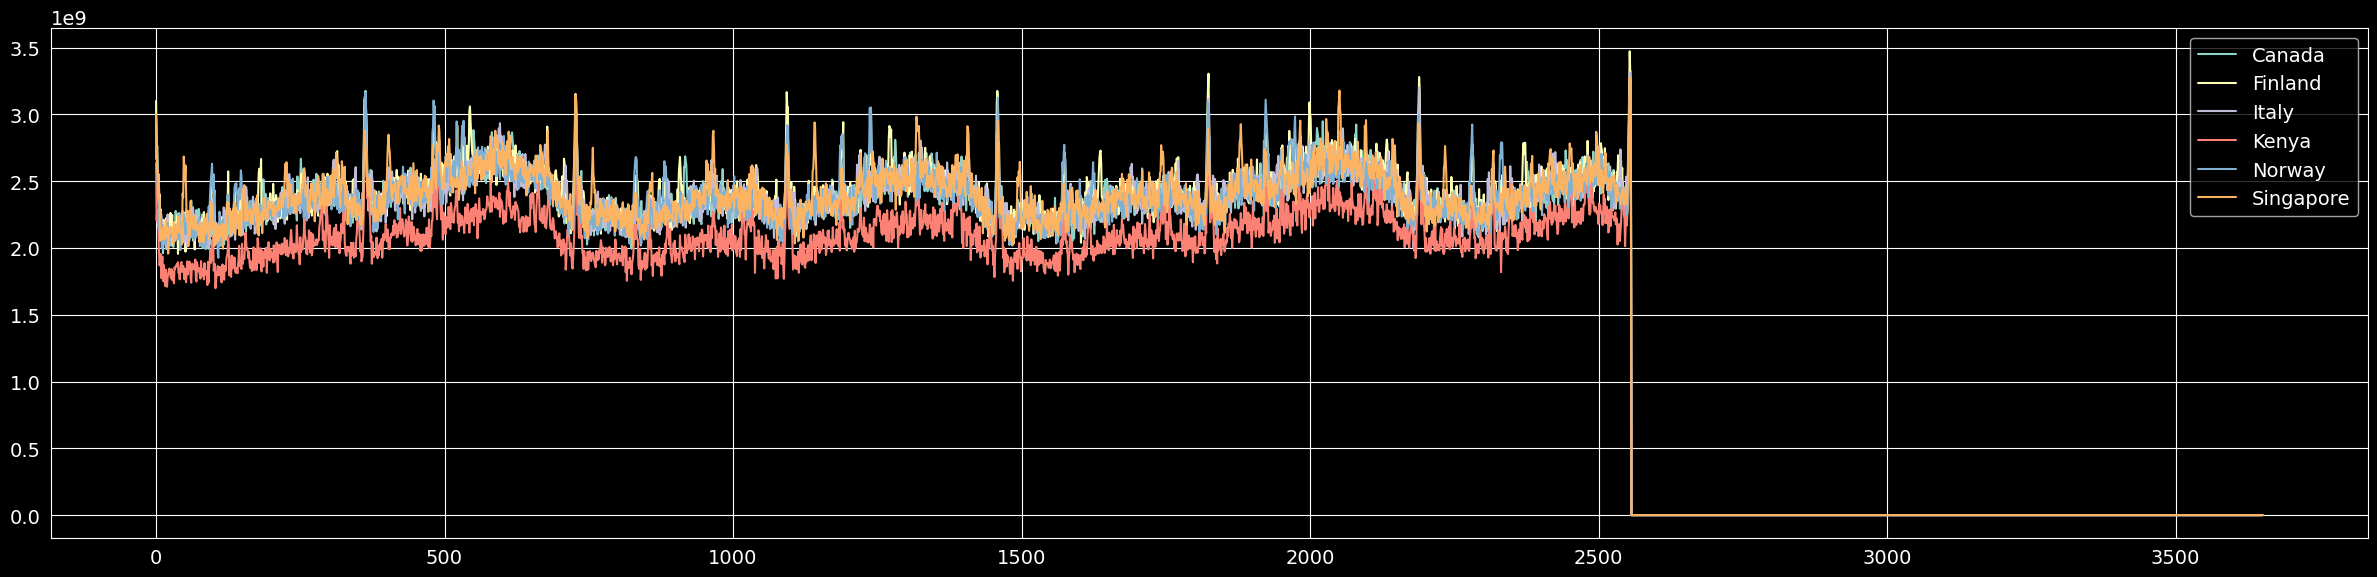

In [76]:
abt['ratio'] = abt['gdp_factor'] * abt['product_factor'] * abt['store_factor'] * abt['weekday_factor'] * abt['sincos_factor']

# The total sold items taking into account all factors
abt['total'] = abt['num_sold'] / abt['ratio']

fig = plt.figure(figsize=(24,6))
for c in CFG.countries:
    abt_p = abt[(abt.country == c) & (abt['product'] == 'Kaggle')].groupby('date').total.sum().to_numpy()
    plt.plot(abt_p, label=c)

plt.legend();

In [28]:
country_factor = abt[(abt['product'] == 'Kaggle')].groupby('country').total.sum().rename('country_factor')
country_factor = country_factor / country_factor.median()
abt = abt.join(country_factor, on='country', how='left')

In [55]:
abt.head()

,id,date,country,store,product,num_sold,test,year,month,weekday,...,product_factor,holiday,weekday_factor,ratio,total,store_factor,dayofyear_factor,sincos_factor,country_factor,prediction
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,0,2010,1,4,...,0.053238,0,0.142919,0.0,NaN,495.49388,7.979592e-13,8.267075e-13,0.998744,140.641376
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,0,2010,1,4,...,0.338008,0,0.142919,0.000001,1035154899.266237,495.49388,7.979592e-13,8.267075e-13,0.998744,892.932405
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,0,2010,1,4,...,0.278552,0,0.142919,0.000001,1169609991.861838,495.49388,7.979592e-13,8.267075e-13,0.998744,735.865113
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,0,2010,1,4,...,0.152072,0,0.142919,0.0,1000252538.72047,495.49388,7.979592e-13,8.267075e-13,0.998744,401.736962
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,0,2010,1,4,...,0.178131,0,0.142919,0.0,991201874.913461,495.49388,7.979592e-13,8.267075e-13,0.998744,470.576747


In [54]:
abt['ratio'] = abt['gdp_factor'] * abt['product_factor'] * abt['store_factor'] * abt['weekday_factor'] * abt['sincos_factor'] * abt['country_factor']

abt['total'] = abt['num_sold'] / abt['ratio']
const_factor = abt['total'].median() * 1.2

abt['prediction'] = const_factor * abt['ratio']
mape_train = mean_absolute_percentage_error(abt[(abt.test == 0) & (~pd.isna(abt.num_sold))].num_sold, abt[(abt.test == 0) & (~pd.isna(abt.num_sold))].prediction)

print(f'{mape_train=}')

mape_train=0.2042678047687842


In [51]:
abt['prediction'] = np.round(abt['prediction'].astype(float)).astype(int)

In [52]:
submission = abt[(abt.test == 1)][['id', 'prediction']].rename(columns={'prediction': 'num_sold'})
submission.to_csv('submission.csv', index=False)

!head submission.csv

id,num_sold
230130,143
230131,910
230132,749
230133,410
230134,480
230135,290
230136,1840
230137,1516
230138,829


In [53]:
!kaggle competitions submit -c playground-series-s5e1 -f submission.csv -m "a0.01"

100%|███████████████████████████████████████| 1.04M/1.04M [00:03<00:00, 345kB/s]
Successfully submitted to Forecasting Sticker Sales

Exception